In [1]:
# ============================================
# Video Game Sales Project Pipeline
# ============================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import mlflow.sklearn

In [3]:
import os
import urllib.request
import urllib.error
import mlflow

def _resolve_mlflow_tracking_uri(server_uri: str, fallback_dir: str = "mlruns") -> str:
    try:
        with urllib.request.urlopen(server_uri, timeout=2):
            return server_uri
    except (urllib.error.URLError, ConnectionError, TimeoutError):
        local_path = os.path.abspath(fallback_dir)
        return f"file:///{local_path.replace(os.sep, '/')}"

tracking_uri = _resolve_mlflow_tracking_uri("http://localhost:5000")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow tracking URI: {tracking_uri}")

# If the server is running, open http://localhost:5000 in your browser to view the UI.

MLflow tracking URI: http://localhost:5000


In [4]:
sns.set(style="whitegrid")
RANDOM_STATE = 42

# Ensure saved PNGs include labels/titles
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.2

def save_plot(path, fig=None, tight=True, rect=None, dpi=300):
    if fig is None:
        fig = plt.gcf()
    if tight:
        if rect is None:
            fig.tight_layout()
        else:
            fig.tight_layout(rect=rect)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    return path

In [5]:

# --- Load Data ---
df = pd.read_csv("vgsales.csv")
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [6]:
# --- Preprocessing ---
# Handle missing values
df['Publisher'].fillna('Unknown', inplace=True)
df['Year'].fillna(df['Year'].median(), inplace=True)

# Encode categorical features
le_platform = LabelEncoder()
le_genre = LabelEncoder()
le_publisher = LabelEncoder()

df['Platform_enc'] = le_platform.fit_transform(df['Platform'])
df['Genre_enc'] = le_genre.fit_transform(df['Genre'])
df['Publisher_enc'] = le_publisher.fit_transform(df['Publisher'])

# Features for clustering and classification
features = ['Platform_enc','Publisher_enc','Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


C:\Users\ULTRAPC\AppData\Local\Temp\ipykernel_22572\1538281199.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Publisher'].fillna('Unknown', inplace=True)
C:\Users\ULTRAPC\AppData\Local\Temp\ipykernel_22572\1538281199.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [7]:
# --- Dimensionality Reduction ---
# PCA 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

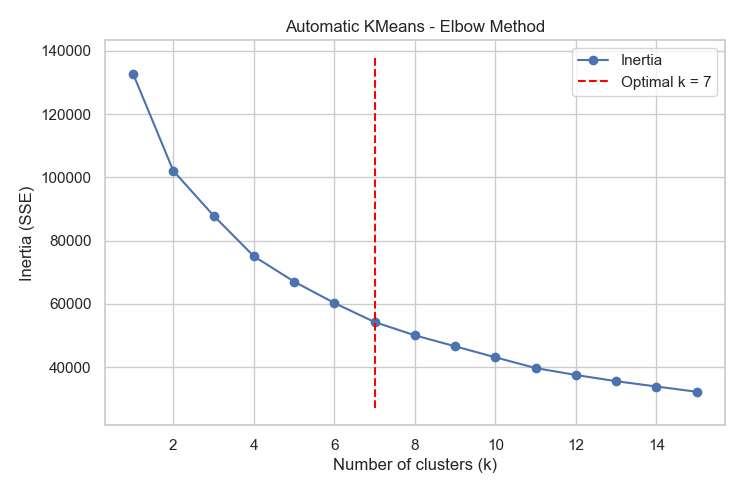

Optimal number of clusters detected: 7


In [8]:
# --- Clustering (Automatic KMeans) ---
def optimal_k_elbow_manual(X_scaled, max_k=15, threshold=0.1):
    inertia = []
    K = range(1, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init=50, random_state=RANDOM_STATE)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    rel_decrease = [(inertia[i-1] - inertia[i])/inertia[i-1] for i in range(1, len(inertia))]
    optimal_k = 2
    for i, dec in enumerate(rel_decrease):
        if dec < threshold:
            optimal_k = i + 2
            break
    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(K, inertia, 'bo-', label='Inertia')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Optimal k = {optimal_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (SSE)')
    plt.title('Automatic KMeans - Elbow Method')
    plt.legend()
    plt.show()
    print(f"Optimal number of clusters detected: {optimal_k}")
    return optimal_k

optimal_k = optimal_k_elbow_manual(X_scaled, max_k=15, threshold=0.1)

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, n_init=50, random_state=RANDOM_STATE)
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)


In [9]:
# --- Classification ---
# Train/Test split
y = df['Genre_enc']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# --- Random Forest with GridSearch ---
rf_params = {
    'n_estimators':[100,200],
    'max_depth':[10,20,None],
    'max_features':['sqrt','log2'],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]
}
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)
print(classification_report(y_test, y_pred_rf, target_names=le_genre.classes_))

# --- SGDClassifier with GridSearch ---
sgd_params = {
    'loss':['log_loss'],
    'penalty':['l2','elasticnet'],
    'alpha':[0.001,0.01],
    'max_iter':[1000,2000],
    'tol':[1e-3,1e-4]
}
sgd = SGDClassifier(random_state=RANDOM_STATE)
sgd_grid = GridSearchCV(sgd, sgd_params, cv=3, n_jobs=-1, verbose=1)
sgd_grid.fit(X_train, y_train)
best_sgd = sgd_grid.best_estimator_

y_pred_sgd = best_sgd.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)
print("SGDClassifier Accuracy:", acc_sgd)
print(classification_report(y_test, y_pred_sgd, target_names=le_genre.classes_))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Random Forest Accuracy: 0.32349397590361445
              precision    recall  f1-score   support

      Action       0.31      0.63      0.42       663
   Adventure       0.35      0.28      0.31       257
    Fighting       0.52      0.07      0.12       170
        Misc       0.30      0.22      0.25       348
    Platform       0.41      0.16      0.23       177
      Puzzle       0.23      0.09      0.13       116
      Racing       0.30      0.08      0.13       250
Role-Playing       0.34      0.36      0.35       298
     Shooter       0.26      0.06      0.10       262
  Simulation       0.25      0.09      0.13       174
      Sports       0.35      0.58      0.43       469
    Strategy       0.33      0.20      0.25       136

    accuracy                           0.32      3320
   macro avg       0.33      0.23      0.24      3320
weighted avg       0.33      0.32      0.28      3320

Fitting 3 folds for each of

c:\Users\ULTRAPC\.conda\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ULTRAPC\.conda\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ULTRAPC\.conda\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [10]:
# --- MLflow Tracking ---
mlflow.set_experiment("VideoGameSales_Project")
with mlflow.start_run():
    # Log Parameters
    mlflow.log_param("RandomForest_params", best_rf.get_params())
    mlflow.log_param("SGDClassifier_params", best_sgd.get_params())
    mlflow.log_param("Optimal_k_clusters", optimal_k)
    
    # Log Metrics
    mlflow.log_metric("RF_Accuracy", acc_rf)
    mlflow.log_metric("SGD_Accuracy", acc_sgd)
    
    # Log Models
    mlflow.sklearn.log_model(best_rf, "RandomForest_model")
    mlflow.sklearn.log_model(best_sgd, "SGD_model")
    
    # Log PCA plots
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster_KMeans'], cmap='Set1', s=50)
    plt.title("PCA Scatter Plot Colored by Cluster")
    plt.xlabel("PCA1"); plt.ylabel("PCA2")
    save_plot("PCA_clusters.png")
    mlflow.log_artifact("PCA_clusters.png")
    plt.close()
    
    # Log cluster heatmap
    cluster_means = df.groupby('Cluster_KMeans')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].mean()
    sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Cluster Average Sales")
    save_plot("cluster_heatmap.png")
    mlflow.log_artifact("cluster_heatmap.png")
    plt.close()

2026/02/01 20:43:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 20:43:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/02/01 20:43:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/01 20:43:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run efficient-zebra-117 at: http://localhost:5000/#/experiments/761854136110779325/runs/1a0465887bb4430a949e96fb9646fe00
🧪 View experiment at: http://localhost:5000/#/experiments/761854136110779325


In [11]:

# --- Top Games per Cluster ---
top_games_per_cluster = {}
for i in range(optimal_k):
    top_games = df[df['Cluster_KMeans']==i][['Name','Global_Sales']].sort_values(by='Global_Sales', ascending=False).head(10)
    top_games_per_cluster[i] = top_games
    print(f"Top 10 Games in Cluster {i}:\n", top_games, "\n")


Top 10 Games in Cluster 0:
                                                   Name  Global_Sales
468                                           NBA 2K13          3.00
507                   The Elder Scrolls III: Morrowind          2.86
549                                         L.A. Noire          2.72
568                                              Fable          2.66
578                                          Halo Wars          2.63
580                                       ESPN NFL 2K5          2.62
584                                           NBA 2K12          2.62
610                                         Game Party          2.52
617  Rockstar Games Double Pack: Grand Theft Auto I...          2.49
618                       LEGO Harry Potter: Years 1-4          2.49 

Top 10 Games in Cluster 1:
                                          Name  Global_Sales
43                                     Halo 3         12.14
46                             Super Mario 64         11.89
48 

In [12]:
#                                    ============================================
#                                      Additional Visualizations (MLflow logging)
#                                    ============================================

In [13]:

# Set Seaborn style
#sns.set(style="whitegrid")

# Start MLflow run (continued from previous run or new run)
with mlflow.start_run(run_name="Visualizations", nested=True):

    # -----------------------------
    #  Distribution of Sales per Region
    # -----------------------------
    regions = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']
    plt.figure(figsize=(15,5))
    df[regions].hist(bins=30, layout=(1,5), color='skyblue')
    plt.suptitle("Distribution of Sales by Region")
    save_plot("Sales_Distribution.png", rect=[0, 0, 1, 0.95])
    mlflow.log_artifact("Sales_Distribution.png")
    plt.close()

    # -----------------------------
    # Sales Trends by Year
    # -----------------------------
    sales_by_year = df.groupby('Year')[regions].sum().reset_index()
    plt.figure(figsize=(12,6))
    for region in regions:
        plt.plot(sales_by_year['Year'], sales_by_year[region], label=region)
    plt.xlabel("Year"); plt.ylabel("Sales (Millions)")
    plt.title("Sales Trends by Region over Time")
    plt.legend()
    save_plot("Sales_Trends.png")
    mlflow.log_artifact("Sales_Trends.png")
    plt.close()

    # -----------------------------
    # Sales by Platform and Genre
    # -----------------------------
    plt.figure(figsize=(12,5))
    platform_sales = df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)
    sns.barplot(x=platform_sales.index, y=platform_sales.values, palette="viridis")
    plt.xticks(rotation=45, ha='right'); plt.title("Global Sales by Platform")
    save_plot("Sales_by_Platform.png")
    mlflow.log_artifact("Sales_by_Platform.png")
    plt.close()

    plt.figure(figsize=(12,5))
    genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
    sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="coolwarm")
    plt.xticks(rotation=45, ha='right'); plt.title("Global Sales by Genre")
    save_plot("Sales_by_Genre.png")
    mlflow.log_artifact("Sales_by_Genre.png")
    plt.close()

    # -----------------------------
    # Cluster Analysis Visualizations
    # -----------------------------
    # Cluster centroids heatmap
    cluster_means = df.groupby('Cluster_KMeans')[regions].mean()
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Average Sales per Cluster")
    save_plot("Cluster_Heatmap.png")
    mlflow.log_artifact("Cluster_Heatmap.png")
    plt.close()

    # Cluster distribution by Genre
    plt.figure(figsize=(10,5))
    sns.countplot(x='Cluster_KMeans', hue='Genre', data=df)
    plt.title("Cluster Distribution by Genre")
    save_plot("Cluster_Distribution_Genre.png")
    mlflow.log_artifact("Cluster_Distribution_Genre.png")
    plt.close()

    # -----------------------------
    # Random Forest Feature Importance
    # -----------------------------
    importances = best_rf.feature_importances_
    plt.figure(figsize=(8,5))
    sns.barplot(x=features, y=importances, palette="magma")
    plt.title("Random Forest Feature Importance")
    save_plot("RF_Feature_Importance.png")
    mlflow.log_artifact("RF_Feature_Importance.png")
    plt.close()

    # -----------------------------
    #  PCA 3D Scatter Plot
    # -----------------------------
    from mpl_toolkits.mplot3d import Axes3D
    pca_3d = PCA(n_components=3)
    X_pca_3d = pca_3d.fit_transform(X_scaled)

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2],
                         c=df['Cluster_KMeans'], cmap='Set1', s=50)
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.title("3D PCA Scatter Plot Colored by Cluster")
    save_plot("PCA_3D_Clusters.png", fig=fig)
    mlflow.log_artifact("PCA_3D_Clusters.png")
    plt.close()

    # -----------------------------
    # Boxplots / Violin Plots by Genre
    # -----------------------------
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Genre', y='Global_Sales', data=df)
    plt.xticks(rotation=45, ha='right'); plt.title("Boxplot of Global Sales by Genre")
    save_plot("Boxplot_Genre.png")
    mlflow.log_artifact("Boxplot_Genre.png")
    plt.close()

    plt.figure(figsize=(12,6))
    sns.violinplot(x='Genre', y='Global_Sales', data=df, inner='quartile', palette="Set2")
    plt.xticks(rotation=45, ha='right'); plt.title("Violin Plot of Global Sales by Genre")
    save_plot("Violin_Genre.png")
    mlflow.log_artifact("Violin_Genre.png")
    plt.close()

    # -----------------------------
    #  Top 10 Games per Cluster (bar charts)
    # -----------------------------
    for i in range(optimal_k):
        top_games = df[df['Cluster_KMeans']==i][['Name','Global_Sales']].sort_values(
            by='Global_Sales', ascending=False).head(10)
        plt.figure(figsize=(8,5))
        sns.barplot(x='Global_Sales', y='Name', data=top_games, palette='viridis')
        plt.title(f"Top 10 Games in Cluster {i} by Global Sales")
        plt.xlabel("Global Sales (Millions)")
        save_plot(f"Top10Games_Cluster_{i}.png")
        mlflow.log_artifact(f"Top10Games_Cluster_{i}.png")
        plt.close()

C:\Users\ULTRAPC\AppData\Local\Temp\ipykernel_22572\3318610270.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_sales.index, y=platform_sales.values, palette="viridis")
C:\Users\ULTRAPC\AppData\Local\Temp\ipykernel_22572\3318610270.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="coolwarm")
C:\Users\ULTRAPC\AppData\Local\Temp\ipykernel_22572\3318610270.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=importances, palette="magma")
C:\Users\ULTRAPC\AppData

🏃 View run Visualizations at: http://localhost:5000/#/experiments/761854136110779325/runs/b371cc490522462597ea1a7659c5c4a0
🧪 View experiment at: http://localhost:5000/#/experiments/761854136110779325


<Figure size 1500x500 with 0 Axes>

In [14]:
#                               ============================================
#                                        Neural Networks using PyTorch
#                               ============================================


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch Version: {torch.__version__}")

Device: cpu
PyTorch Version: 2.8.0


In [17]:
# --- Data Preparation for PyTorch ---
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)


In [18]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

print(f"Input dimensions: {input_dim}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Input dimensions: 8
Number of classes: 12
Training samples: 13278, Test samples: 3320



Building Shallow Neural Network (PyTorch)...
ShallowNN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
)
Epoch 20/100, Train Loss: 2.1381, Val Loss: 2.1298, Val Acc: 0.2566
Epoch 40/100, Train Loss: 2.0971, Val Loss: 2.0953, Val Acc: 0.2702
Epoch 60/100, Train Loss: 2.0753, Val Loss: 2.0735, Val Acc: 0.2783
Epoch 80/100, Train Loss: 2.0618, Val Loss: 2.0581, Val Acc: 0.2931
Epoch 100/100, Train Loss: 2.0441, Val Loss: 2.0533, Val Acc: 0.2895

Shallow Neural Network Accuracy: 0.2895
              precision    recall  f1-score   support

      Action       0.28      0.63      0.38       663
   Adventure       0.34      0.28      0.31       257
    Fighting       0.27      0.08      0.13       170
        Misc       0.23      0.14      0.18       348
  

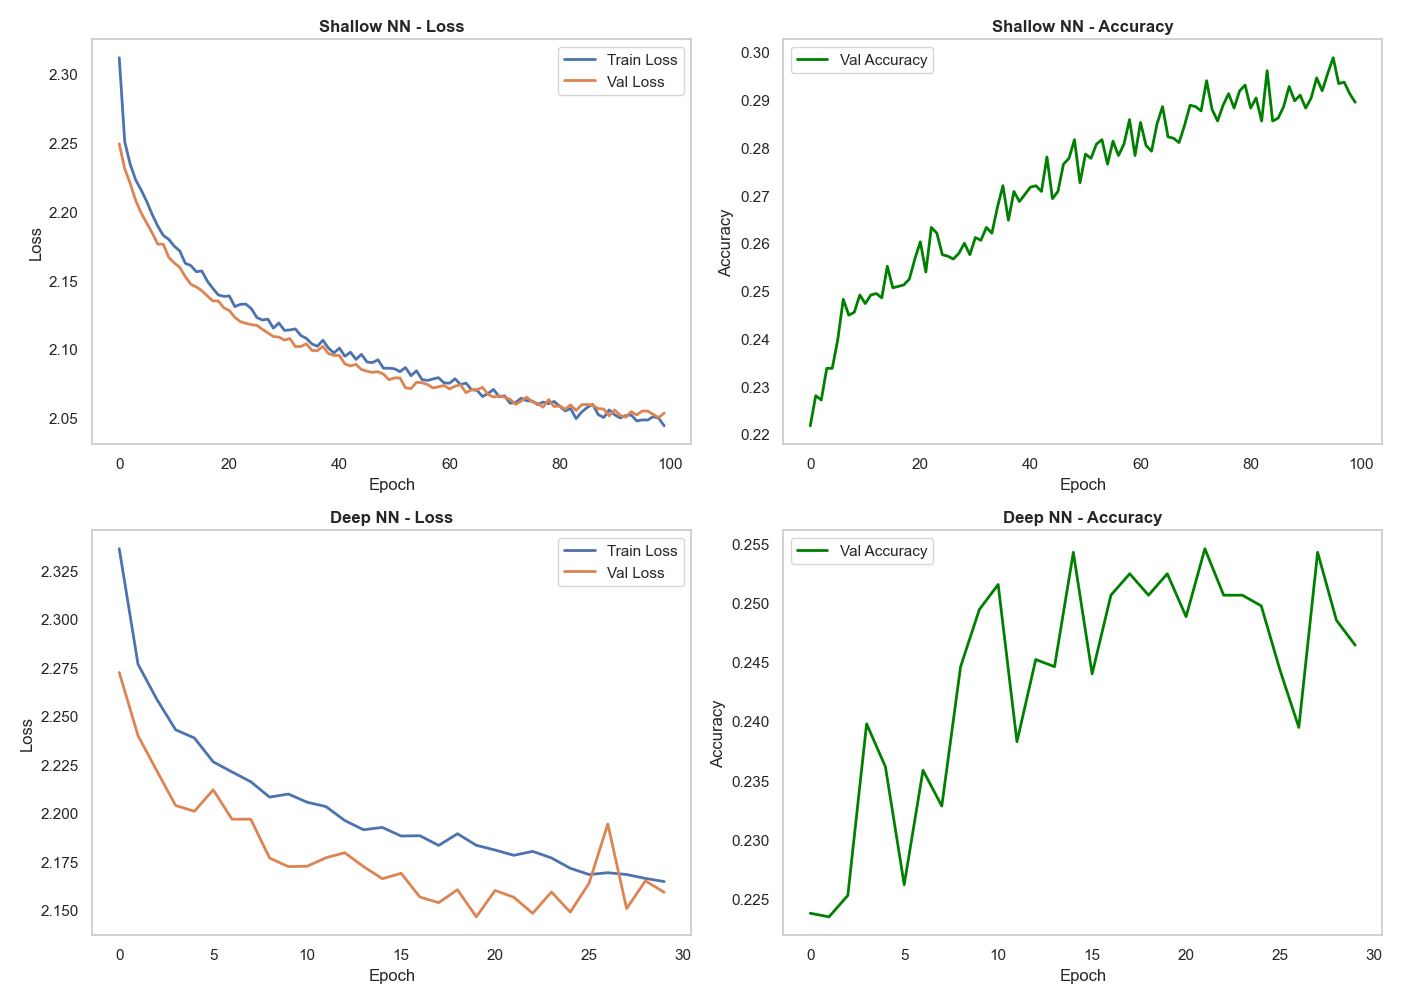

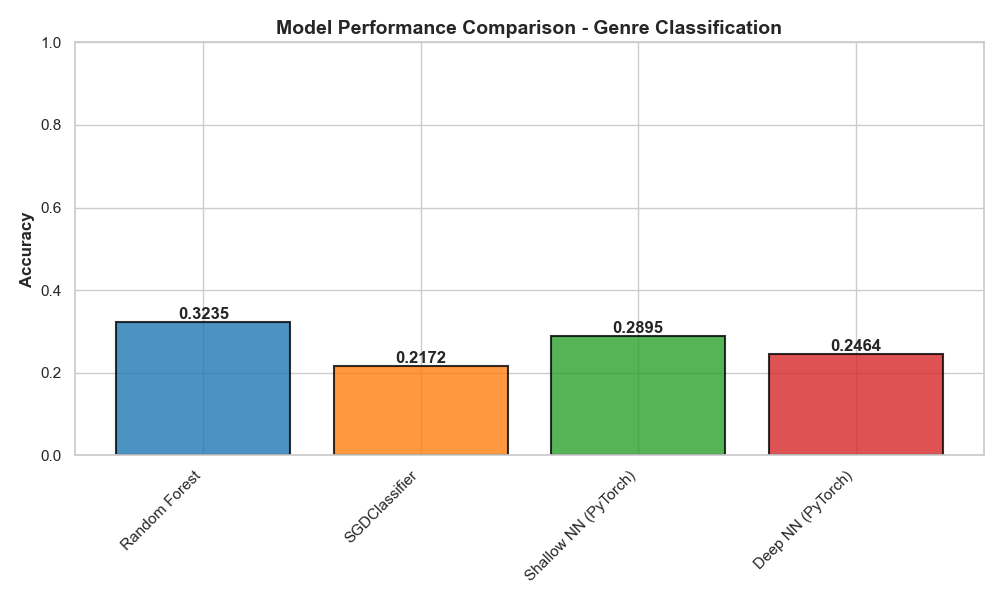


FINAL RESULTS - ALL MODELS (PyTorch)
Random Forest                 : 0.3235
SGDClassifier                 : 0.2172
Shallow NN (PyTorch)          : 0.2895
Deep NN (PyTorch)             : 0.2464

  PyTorch Neural Network models logged to MLflow!
🏃 View run PyTorch_Neural_Networks at: http://localhost:5000/#/experiments/761854136110779325/runs/830a49b11079404196148249adbab1fd
🧪 View experiment at: http://localhost:5000/#/experiments/761854136110779325


In [19]:
# --- Shallow Neural Network (PyTorch) ---
print("\n" + "="*50)
print("Building Shallow Neural Network (PyTorch)...")
print("="*50)

class ShallowNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ShallowNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

nn_shallow = ShallowNN(input_dim, num_classes).to(device)
print(nn_shallow)

criterion = nn.CrossEntropyLoss()
optimizer_shallow = optim.Adam(nn_shallow.parameters(), lr=0.001)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return val_loss / len(test_loader), correct / total

# Train shallow network
epochs = 100
patience = 10
best_loss = float('inf')
patience_counter = 0
history_shallow = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss = train_epoch(nn_shallow, train_loader, criterion, optimizer_shallow, device)
    val_loss, val_acc = validate(nn_shallow, test_loader, criterion, device)
    
    history_shallow['train_loss'].append(train_loss)
    history_shallow['val_loss'].append(val_loss)
    history_shallow['val_acc'].append(val_acc)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Evaluate shallow network
nn_shallow.eval()
y_pred_shallow = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = nn_shallow(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_shallow.extend(predicted.cpu().numpy())

acc_nn_shallow = accuracy_score(y_test, y_pred_shallow)
print(f"\nShallow Neural Network Accuracy: {acc_nn_shallow:.4f}")
print(classification_report(y_test, y_pred_shallow, target_names=le_genre.classes_))

# --- Deep Neural Network (PyTorch) ---
print("\n" + "="*50)
print("Building Deep Neural Network (PyTorch)...")
print("="*50)

class DeepNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

nn_deep = DeepNN(input_dim, num_classes).to(device)
print(nn_deep)

optimizer_deep = optim.Adam(nn_deep.parameters(), lr=0.0005)

# Train deep network
epochs = 100
patience = 10
best_loss = float('inf')
patience_counter = 0
history_deep = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss = train_epoch(nn_deep, train_loader, criterion, optimizer_deep, device)
    val_loss, val_acc = validate(nn_deep, test_loader, criterion, device)
    
    history_deep['train_loss'].append(train_loss)
    history_deep['val_loss'].append(val_loss)
    history_deep['val_acc'].append(val_acc)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Evaluate deep network
nn_deep.eval()
y_pred_deep = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = nn_deep(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_deep.extend(predicted.cpu().numpy())

acc_nn_deep = accuracy_score(y_test, y_pred_deep)
print(f"\nDeep Neural Network Accuracy: {acc_nn_deep:.4f}")
print(classification_report(y_test, y_pred_deep, target_names=le_genre.classes_))

# --- Training History Visualizations ---
print("\n" + "="*50)
print("Training History Visualizations...")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Shallow NN - Loss
axes[0, 0].plot(history_shallow['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_shallow['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Shallow NN - Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid()

# Shallow NN - Accuracy
axes[0, 1].plot(history_shallow['val_acc'], label='Val Accuracy', linewidth=2, color='green')
axes[0, 1].set_title('Shallow NN - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid()

# Deep NN - Loss
axes[1, 0].plot(history_deep['train_loss'], label='Train Loss', linewidth=2)
axes[1, 0].plot(history_deep['val_loss'], label='Val Loss', linewidth=2)
axes[1, 0].set_title('Deep NN - Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid()

# Deep NN - Accuracy
axes[1, 1].plot(history_deep['val_acc'], label='Val Accuracy', linewidth=2, color='green')
axes[1, 1].set_title('Deep NN - Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout()
plt.savefig("PyTorch_Neural_Networks_Training_History.png", dpi=300)
mlflow.log_artifact("PyTorch_Neural_Networks_Training_History.png")
plt.show()

# ---  All Models Comparison ---
models_comparison = {
    'Random Forest': acc_rf,
    'SGDClassifier': acc_sgd,
    'Shallow NN (PyTorch)': acc_nn_shallow,
    'Deep NN (PyTorch)': acc_nn_deep
}

plt.figure(figsize=(10, 6))
models_list = list(models_comparison.keys())
accuracies = list(models_comparison.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = plt.bar(models_list, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison - Genre Classification', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("PyTorch_Models_Comparison.png", dpi=300)
mlflow.log_artifact("PyTorch_Models_Comparison.png")
plt.show()

print("\n" + "="*50)
print("FINAL RESULTS - ALL MODELS (PyTorch)")
print("="*50)
for model_name, accuracy in models_comparison.items():
    print(f"{model_name:<30}: {accuracy:.4f}")

# --- Log PyTorch Models to MLflow ---
with mlflow.start_run(run_name="PyTorch_Neural_Networks", nested=True):
    mlflow.log_metric("Shallow_NN_Accuracy", acc_nn_shallow)
    mlflow.log_metric("Deep_NN_Accuracy", acc_nn_deep)
    
    # Save PyTorch models
    torch.save(nn_shallow.state_dict(), "shallow_nn_pytorch.pth")
    torch.save(nn_deep.state_dict(), "deep_nn_pytorch.pth")
    mlflow.log_artifact("shallow_nn_pytorch.pth")
    mlflow.log_artifact("deep_nn_pytorch.pth")
    
    print("\n  PyTorch Neural Network models logged to MLflow!")
